# Visualise Embeddings

Using the TensorBoard Embedding Projector, you can graphically represent high dimensional embeddings. This can be helpful in visualizing, examining, and understanding your embedding layers.

What we are going to do:

1) Download the ABO dataset
2) Reformat it in the way the Hugging Face `datasets` library epects
3) Resize the images to a shape the ML model expects
4) Generate embeddings for each image using the chosen model
5) Output the embeddings and tiny images in a format that tensorboard expects
6) Visualise the embeddings in Tensorboard
7) Compute some clustering metrics to evaluate the performance of the chosen embedding model on our dataset.

You will need to add the necissary IAM policies to this notebook role... (WIP)

## Get the ABO dataset and reformat it

In [ ]:
! aws s3 cp s3://amazon-berkeley-objects/archives/abo-images-small.tar .

In [ ]:
! tar -xf abo-images-small.tar

In [1]:
! pip install -q -U pyathena

In [2]:
from pyathena import connect
import pandas as pd

# Create a connection to Athena
conn = connect(s3_staging_dir='s3://demo-athena-stephibb/')

# https://amazon-berkeley-objects.s3.amazonaws.com/index.html#explore
def create_abo_listings ():
    query = f"""
    CREATE EXTERNAL TABLE IF NOT EXISTS `default`.`abo_listings` (
      `brand` array < struct < language_tag:string, value:string >  >,
      `bullet_point` array < struct < language_tag:string, value:string >  >,
      `color` array < struct < language_tag:string, value:string >  >,
      `color_code` array < string >,
      `country` string,
      `domain_name` string,
      `fabric_type` array < struct < language_tag:string, value:string >  >,
      `finish_type` array < struct < language_tag:string, value:string >  >,
      `item_dimensions` struct < height:struct < normalized_value:struct < unit:string, value:float >,  value:float, unit:string >,  length:struct < normalized_value:struct < unit:string, value:float >,  value:float, unit:string >,  width:struct < normalized_value:struct < unit:string, value:float >,  value:float, unit:string >  >,
      `item_id` string,
      `item_keywords` array < struct < language_tag:string, value:string >  >,
      `item_name` array < struct < language_tag:string, value:string >  >,
      `item_shape` array < struct < language_tag:string, value:string >  >,
      `item_weight` array < struct < normalized_value:struct < unit:string, value:float >,  value:float, unit:string >  >,
      `main_image_id` string,
      `marketplace` string,
      `material` array < struct < language_tag:string, value:string >  >,
      `model_name` array < struct < language_tag:string, value:string >  >,
      `model_number` array < struct < language_tag:string, value:string >  >,
      `model_year` array < struct < language_tag:string, value:string >  >,
      `node` array < struct < node_id:bigint, path:string >  >,
      `other_image_id` array < string >,
      `pattern` array < struct < language_tag:string, value:string >  >,
      `product_description` array < struct < language_tag:string, value:string >  >,
      `product_type` array < struct < value:string >  >,
      `spin_id` string,
      `style` array < struct < language_tag:string, value:string >  >,
      `3dmodel_id` string
    )
    ROW FORMAT SERDE
      'org.openx.data.jsonserde.JsonSerDe'
    WITH SERDEPROPERTIES (
      'serialization.format' = '1'
    )
    LOCATION
      's3://amazon-berkeley-objects/listings/metadata/'
    TBLPROPERTIES (
      'has_encrypted_data'='false'
    )
    """
    pd.read_sql(query, conn)
    
def create_abo_images ():
    query = f"""
    CREATE EXTERNAL TABLE IF NOT EXISTS `default`.`abo_images`(
      `image_id` string,
      `height` bigint,
      `width` bigint,
      `path` string
    )
    ROW FORMAT SERDE
      'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
    WITH SERDEPROPERTIES (
      'serialization.format' = ',',
      'field.delim' = ',',
      'skip.header.line.count'='1'
    )
    LOCATION
      's3://amazon-berkeley-objects/images/metadata/'
    TBLPROPERTIES (
      'has_encrypted_data'='false'
    )
    """
    pd.read_sql(query, conn)


def sample ():
    query = f"""
    SELECT product_type[1].value as product_type, main_image_id, abo_images.path
    FROM abo_listings
    INNER JOIN abo_images ON abo_listings.main_image_id=abo_images.image_id
    WHERE product_type[1].value IN ('BASKET',
    'COMPUTER',
    'CONDITIONER',
    'CLOCK',
    'MEASURING_CUP',
    'ICE_CUBE_TRAY',
    'PILLOW',
    'FOOD_PROCESSOR',
    'SOFA',
    'CHAIR',
    'HAT',
    'LAMP',
    'BAKING_PAPER',
    'PHONE',
    'VACUUM_CLEANER',
    'TOASTER',
    'RUG',
    'HEADPHONES',
    'DESK',
    'RADIO',
    'PRINTER',
    'JAR',
    'BED',
    'CUTTING_BOARD',
    'SHAMPOO',
    'CURTAIN',
    'TOOTHBRUSH',
    'BOTTLE_OPENER',
    'SHOES',
    'TELEVISION',
    'DISHWASHER',
    'CAN_OPENER',
    'TABLE',
    'BLANKET',
    'BROOM',
    'PAINT_BRUSH',
    'LOCK',
    'OFFICE_PRODUCTS',
    'FOOD_SLICER',
    'MARKING_PEN',
    'BOTTLE_RACK',
    'HAIR_BRUSH',
    'MEDICATION',
    'CONDIMENT',
    'SHOWERHEAD',
    'POWER_BANK',
    'COOKIE',
    'BOOKEND',
    'SPEAKERS',
    'COSMETIC_POWDER',
    'ROWING_MACHINE',
    'SNACK_FOOD_BAR',
    'TERMINAL_BLOCK',
    'PITCHER',
    'AIR_COMPRESSOR',
    'PRETZEL',
    'THERMOS',
    'LEOTARD',
    'SPORT_RACKET',
    'PUZZLES',
    'DRINK_COASTER',
    'MONITOR',
    'CELLULAR_PHONE',
    'EARMUFF',
    'PORTABLE_AUDIO',
    'BODY_LUBRICANT',
    'AUTO_CHEMICAL',
    'PLANTER',
    'CLEANING_BRUSH',
    'STAPLER',
    'PORTABLE_STOVE',
    'CAMERA_SUPPORT',
    'PROTEIN_DRINK',
    'PICTURE_FRAME',
    'LITTER_BOX',
    'TABLETOP_GAME',
    'WRITING_BOARD',
    'POT_HOLDER',
    'BUCKET',
    'TOWEL_HOLDER',
    'LADDER',
    'BAKING_CUP',
    'BAKING_PAN',
    'CANDLE',
    'BOTTLE',
    'GARLIC_PRESS',
    'STORAGE_BAG',
    'TIMER',
    'CLOTHES_RACK',
    'STORAGE_BOX',
    'WALLET',
    'BABY_BOTTLE',
    'SLEEPING_BAG',
    'FINEOTHER',
    'MICROPHONE',
    'BED_FRAME',
    'WEIGH_SCALE',
    'FLASH_DRIVE',
    'NAIL_POLISH',
    'SHOE_INSERT')
    ORDER BY RAND()
    """
    df = pd.read_sql(query, conn)
    df.to_csv('sample.csv', index=False)

In [3]:
create_abo_listings()
create_abo_images()
sample()

/tmp/ipykernel_8136/3061657889.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)
/tmp/ipykernel_8136/3061657889.py:74: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(query, conn)
/tmp/ipykernel_8136/3061657889.py:184: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


You may wish to start by experimenting with a smaller subset of the full data

In [4]:
import pandas as pd

def save_random_1000_lines(input_filename, output_filename):
    # Read the entire CSV file
    df = pd.read_csv(input_filename)
    
    # Sample 1000 random lines from the DataFrame
    df_sampled = df.sample(n=1000)

    # Save the sampled DataFrame to a new CSV file
    df_sampled.to_csv(output_filename, index=False)

# Replace 'input.csv' with the path to your input CSV file
# Replace 'output_random_1000_lines.csv' with the path where you want to save the new CSV file
save_random_1000_lines('sample.csv', 'sample_1000.csv')


## Reformat the images
Now we have a CSV file with the image IDs we want to create embeddings for, we reformat them and load as a `datasets` dataset

In [5]:
!pip install -U -q scikit-learn

In [6]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

def read_csv(file_path):
    """Read and return the CSV data."""
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        raise FileNotFoundError(f"File {file_path} not found!")

def create_directory(directory_path):
    """Create a directory if it doesn't exist."""
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

def move_images(data, base_dir):
    """Process and move images to the specified directory."""
    for _, row in data.iterrows():
        product_type_dir = os.path.join(base_dir, row['product_type'].lower())
        new_image_name = f"{row['main_image_id'].lower()}.png"
        new_path = os.path.join(product_type_dir, new_image_name)
        
        # Create product type directory if it doesn't exist
        create_directory(product_type_dir)
        
        # Move the image if the source exists
        source_path = f"images/small/{row['path']}"
        if os.path.exists(source_path):
            shutil.copy(source_path, new_path)

def process_dataset(csv_file_path, train_dir, test_dir, test_size=0.20):
    """Split the data into train and test sets and move images."""
    # Read the CSV data
    csv_data = read_csv(csv_file_path)
    
    # Split the data
    train_data, test_data = train_test_split(csv_data, test_size=test_size, random_state=42)
    
    # Create base directories
    create_directory(train_dir)
    create_directory(test_dir)
    
    # Move train and test images
    move_images(train_data, train_dir)
    move_images(test_data, test_dir)

# Sample usage
csv_file_path = "sample_1000.csv"
train_directory = "products/train"
test_directory = "products/test"
process_dataset(csv_file_path, train_directory, test_directory)

In [7]:
! pip install -U -q tensorboard datasets transformers

In [8]:
from datasets import load_dataset
import torch
from transformers import CLIPProcessor, CLIPModel
import torchvision.transforms as T
from PIL import Image
from torchvision import transforms

batch_size=24

# Model and transformation setup
model_ckpt = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_ckpt)
model = CLIPModel.from_pretrained(model_ckpt)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dummy text input
dummy_texts = ["a photo"] * batch_size
dummy_text_inputs = processor(text=dummy_texts, return_tensors="pt", padding=True).to(device)

# Load dataset
ds = load_dataset("imagefolder", data_dir="./products", split="train")

# Extract embeddings function definition
def extract_embeddings(model: torch.nn.Module, processor: CLIPProcessor, dummy_text_inputs):
    """Utility to compute embeddings."""
    device = model.device
    def pp(batch):
        images = batch["image"]
        inputs = processor(images=images, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        inputs["input_ids"] = dummy_text_inputs["input_ids"]
        inputs["attention_mask"] = dummy_text_inputs["attention_mask"]
        with torch.no_grad():
            outputs = model(**inputs)
        return {"embeddings": outputs.image_embeds.cpu()}
    return pp

# Generate embeddings
extract_fn = extract_embeddings(model.to(device), processor, dummy_text_inputs)
emb = ds.map(extract_fn, batched=True, batch_size=24)
print("Embeddings generated.")

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/830 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/217 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Embeddings generated.


In [9]:
def convert_to_3_channels(img):
    if img.mode == 'L':
        img = img.convert("RGB")
    return img

def create_image_tensor(dataset_dict):
    # Define a transformation pipeline: Convert to RGB, resize, then convert to tensor
    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB")),  # Convert to RGB
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    # Extract and transform images from train, validation, and test splits
    images = [transform(img) for img in dataset_dict['image']]
    
    all_images = torch.stack(images)
    
    return all_images

In [10]:
from torch.utils.tensorboard import SummaryWriter

# Convert each inner list to a tensor
tensor_embeddings = [torch.tensor(inner_list) for inner_list in emb["embeddings"]]
embeddings = torch.stack(tensor_embeddings, dim=0)
print(f"Shape of embeddings: {embeddings.shape}")

labels = ds.features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

metadata = [id2label[i] for i in ds["label"]]

image_tensor = create_image_tensor(ds)

print(image_tensor.shape)

# Initialize TensorBoard writer
output_dir = "products-1000"
writer = SummaryWriter(output_dir)

writer.add_embedding(
    mat=embeddings,
    metadata=metadata,
    label_img=image_tensor,  # Passing the tensor directly
    tag="ViT Embeddings"
)
print("Embeddings logged to TensorBoard.")

# Close the writer
writer.close()
print("Writer closed.")

Shape of embeddings: torch.Size([830, 512])
torch.Size([830, 3, 64, 64])
Embeddings logged to TensorBoard.
Writer closed.


Now we can open a terminal shell and run tensorboard, pointing to the output directory.

`pip install tensorboard`

`tensorboard --logdir products-1000`

Now duplicate this tab and add `/proxy/6006/ on the end. Don't forget the last forward slash`

`https://dbz-shs7.notebook.eu-west-1.sagemaker.aws/proxy/6006`

In [36]:
# Save the embeddings and metadata to files
torch.save(embeddings, 'embeddings.pth')
with open('metadata.txt', 'w') as f:
    for label in metadata:
        f.write(f"{label}\n")

print("Files 'embeddings.pth' and 'metadata.txt' saved.")

Files 'embeddings.pth' and 'metadata.txt' saved.


In [11]:
emb

Dataset({
    features: ['image', 'label', 'embeddings'],
    num_rows: 830
})

# Evaluating the clustering

Since we have the ground-truth labels for our image catagories, we can be more rigorous in our evaluation of the clustering. Let's plot the reduced dimentional vectors in 2D and calculate some common metrics.

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import KMeans

# Function to load TSV file
def load_tsv(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        data = [line.strip().split('\t') for line in lines]
    return data

# Function to convert a list of lists (where inner lists are string representations of numbers) to a PyTorch tensor
def convert_to_tensor(data):
    return torch.tensor([[float(value) for value in row] for row in data])

# Function to perform t-SNE reduction and plot with metrics
def plot_tsne_with_metrics(embeddings, labels, metrics_text, plot_title, save_path=None):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    plt.figure(figsize=(12, 8))
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    for i, label in enumerate(unique_labels):
        idxs = np.array(labels) == label
        plt.scatter(reduced_embeddings[idxs, 0], reduced_embeddings[idxs, 1], label=label, color=colors[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=1)
    plt.title(plot_title)
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    # Place metrics text on the plot
    plt.figtext(0.5, -0.2, metrics_text, ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    if save_path:
        plt.savefig(save_path, dpi=100, bbox_inches="tight", pad_inches=1)
    plt.show()

# Function to calculate clustering metrics
def calculate_clustering_metrics(embeddings, true_labels, predicted_labels):
    ari = metrics.adjusted_rand_score(true_labels, predicted_labels)
    homogeneity = metrics.homogeneity_score(true_labels, predicted_labels)
    completeness = metrics.completeness_score(true_labels, predicted_labels)
    v_measure = metrics.v_measure_score(true_labels, predicted_labels)
    silhouette = metrics.silhouette_score(embeddings, predicted_labels, metric='euclidean')
    metrics_text = f"Adjusted Rand Index: {ari:.3f}\n"
    metrics_text += f"Homogeneity: {homogeneity:.3f}\n"
    metrics_text += f"Completeness: {completeness:.3f}\n"
    metrics_text += f"V-Measure: {v_measure:.3f}\n"
    metrics_text += f"Silhouette Score: {silhouette:.3f}"
    print(metrics_text.replace("\n", " "))
    return metrics_text


In [15]:
# Parameters for easy change for different experiments
BASE_PATHS = ['products-1000/00000/ViT Embeddings']
MODELS = ['openai/clip-vit-base-patch32']

openai/clip-vit-base-patch32
Loaded 830 embeddings and 830 labels.


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.089 Homogeneity: 0.814 Completeness: 0.442 V-Measure: 0.573 Silhouette Score: 0.084


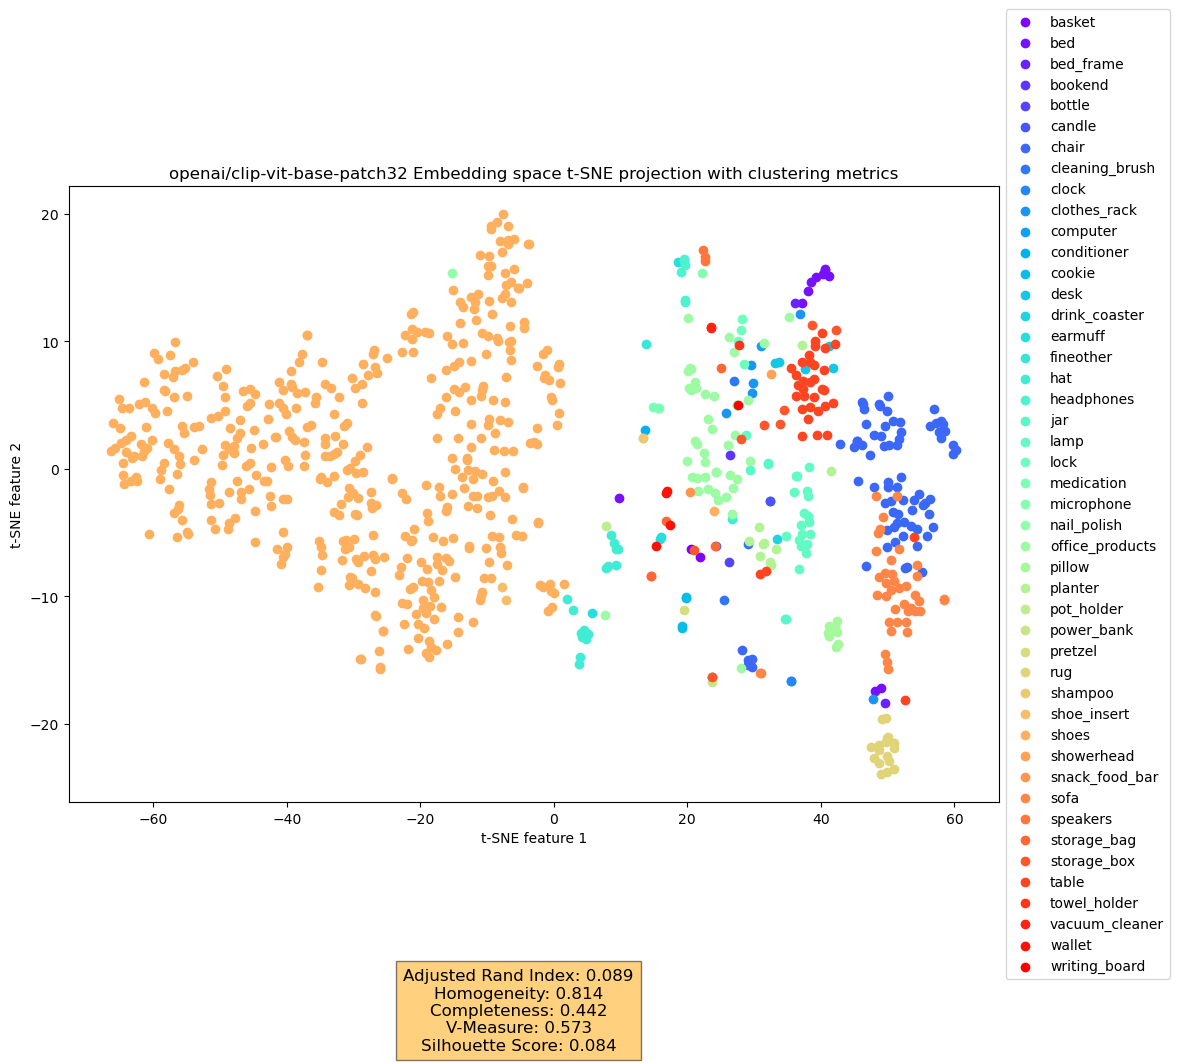

In [16]:
i = 0
for BASE_PATH in BASE_PATHS:
    print(MODELS[i])
    # Load data and convert to embeddings and labels
    tensor_file_path = f'{BASE_PATH}/tensors.tsv'
    tensor_data = load_tsv(tensor_file_path)
    embeddings = convert_to_tensor(tensor_data)
    metadata_file_path = f'{BASE_PATH}/metadata.tsv'
    metadata_data = load_tsv(metadata_file_path)
    metadata = [row[0] for row in metadata_data]  # Adjust if metadata has a different structure
    print(f"Loaded {len(embeddings)} embeddings and {len(metadata)} labels.")

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=len(np.unique(metadata)), random_state=42).fit(embeddings)
    predicted_labels = kmeans.labels_

    # Calculate clustering metrics
    metrics_text = calculate_clustering_metrics(embeddings, metadata, predicted_labels)

    # Perform t-SNE and plot with metrics
    plot_title = f"{MODELS[i]} Embedding space t-SNE projection with clustering metrics"
    plot_tsne_with_metrics(embeddings, metadata, metrics_text, plot_title, MODELS[i].split("/")[1])
    i += 1

# Clustering Metrics Explanation

## 1. Adjusted Rand Index (ARI)
- **Value**: 0.089
- **Explanation**: Measures the similarity between two clusterings, adjusted for chance. ARI ranges from 1 (perfect) to negative values (less than random).
- **Interpretation**: An ARI of 0.089 indicates slight alignment with true labels, but close to random chance, suggesting relatively poor performance.

## 2. Homogeneity
- **Value**: 0.814
- **Explanation**: Assesses if each cluster contains only members of a single class. Scores range from 1 (perfect homogeneity) to 0.
- **Interpretation**: A high score of 0.814 suggests good internal consistency within clusters.

## 3. Completeness
- **Value**: 0.442
- **Explanation**: Measures if all members of a given class are assigned to the same cluster. Scores range from 1 (all members of a class in one cluster) to 0.
- **Interpretation**: A score of 0.442 indicates moderate performance in grouping all class members into a single cluster.

## 4. V-Measure
- **Value**: 0.573
- **Explanation**: The harmonic mean of homogeneity and completeness, providing an overall measure of clustering quality.
- **Interpretation**: A V-Measure of 0.573 indicates average performance, balancing homogeneity and completeness.

## 5. Silhouette Score
- **Value**: 0.084
- **Explanation**: Measures the similarity of an object to its own cluster compared to other clusters, ranging from -1 (incorrect) to +1 (highly dense). A score around 0 indicates overlapping clusters.
- **Interpretation**: A score of 0.084 suggests poorly defined clusters with considerable overlap or closeness, indicating poor clustering quality.

# Summary
These metrics collectively indicate that while clusters are internally consistent (high homogeneity), they do not effectively encapsulate all class members (moderate completeness) and lack clear separation (low silhouette score). The overall clustering performance (V-Measure) is average, with alignment to true labels slightly better than random (ARI).

This may well be sufficient for some use-cases, for example image similarity search where getting an exact match all the time is not critcal since you can return a selection of results in the user interface and have a human do the final selection - ignoring false positives. Try swapping out the embedding model and see if you can improve clustering performance.
